## Import Lib

In [39]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
palette = itertools.cycle(sns.color_palette())

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## Import Data

In [40]:
# Read the CSV file into a pandas DataFrame and display the first few rows
path_ella = 'C:/Users/ellad/Desktop/MB_ML/Projekt/train_heart.csv'
path_train = './train_heart.csv'
path_test = './test_heart.csv'
df_train = pd.read_csv(path_train)
df_train.head()
df_test = pd.read_csv(path_test)
df_test.head()

print("Training Dataset size:", len(df_train))
print("Test Dataset size:", len(df_test))

print('Training data shape: ',df_train.shape)
print('Test data shape: ',df_test.shape)
#________________________________________________



Training Dataset size: 1025
Test Dataset size: 303
Training data shape:  (1025, 14)
Test data shape:  (303, 14)


## Fix Train/test data

In [28]:
#_________Training____________
mat = df_train.values
X_train = mat[:,0:-1]
print('x_train shape: ',X_train.shape)
y_train = mat[:,-1].astype("int")
print('y_train shape: ',y_train.shape)
ind = mat[:,1].astype("int")  #and get the indexes
#print(ind.shape)

# standardize input features
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
#print(X_train.shape)

print(' ')
#_________Test____________
mat = df_test.values
X_test = mat[:,0:-1]
print('x_test shape: ',X_test.shape)
y_test = mat[:,-1].astype("int")
print('x_test shape: ',y_test.shape)
ind = mat[:,1].astype("int")  #and get the indexes
#print(ind.shape)

# standardize input features
X_mean = X_test.mean(axis=0)
X_std = X_test.std(axis=0)
X_test = (X_test - X_mean) / X_std
#print(X_test.shape)



x_train shape:  (1025, 13)
y_train shape:  (1025,)
 
x_test shape:  (303, 13)
x_test shape:  (303,)


## Simple sklearn LogReg

In [30]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', C=1)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
#print("predictions:", y_hat)
# print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

Accuracy: 0.8613861386138614


## Complicated LogReg

In [41]:
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 
                                            5.*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [43]:


n_cat = 2
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 40000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

/var/folders/rl/2d6x2yy927z8k4n7s2v1ng3m0000gn/T/ipykernel_18047/1190492534.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
/var/folders/rl/2d6x2yy927z8k4n7s2v1ng3m0000gn/T/ipykernel_18047/1190492534.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()


[0] ELBO: 3183.8
[1000] ELBO: 794.7
[2000] ELBO: 481.5
[3000] ELBO: 463.3
[4000] ELBO: 458.8
[5000] ELBO: 462.2
[6000] ELBO: 455.8
[7000] ELBO: 450.2
[8000] ELBO: 454.7
[9000] ELBO: 450.9
[10000] ELBO: 456.9
[11000] ELBO: 449.8
[12000] ELBO: 444.7
[13000] ELBO: 452.0
[14000] ELBO: 446.6
[15000] ELBO: 448.3
[16000] ELBO: 442.2
[17000] ELBO: 446.5
[18000] ELBO: 436.5
[19000] ELBO: 440.2
[20000] ELBO: 446.6
[21000] ELBO: 443.8
[22000] ELBO: 447.3
[23000] ELBO: 457.9
[24000] ELBO: 448.1
[25000] ELBO: 439.7
[26000] ELBO: 445.6
[27000] ELBO: 438.1
[28000] ELBO: 437.3
[29000] ELBO: 444.9
[30000] ELBO: 442.1
[31000] ELBO: 445.2
[32000] ELBO: 440.9
[33000] ELBO: 455.8
[34000] ELBO: 432.4
[35000] ELBO: 440.9
[36000] ELBO: 440.9
[37000] ELBO: 437.2
[38000] ELBO: 442.8
[39000] ELBO: 435.3


In [49]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, y_train-1)

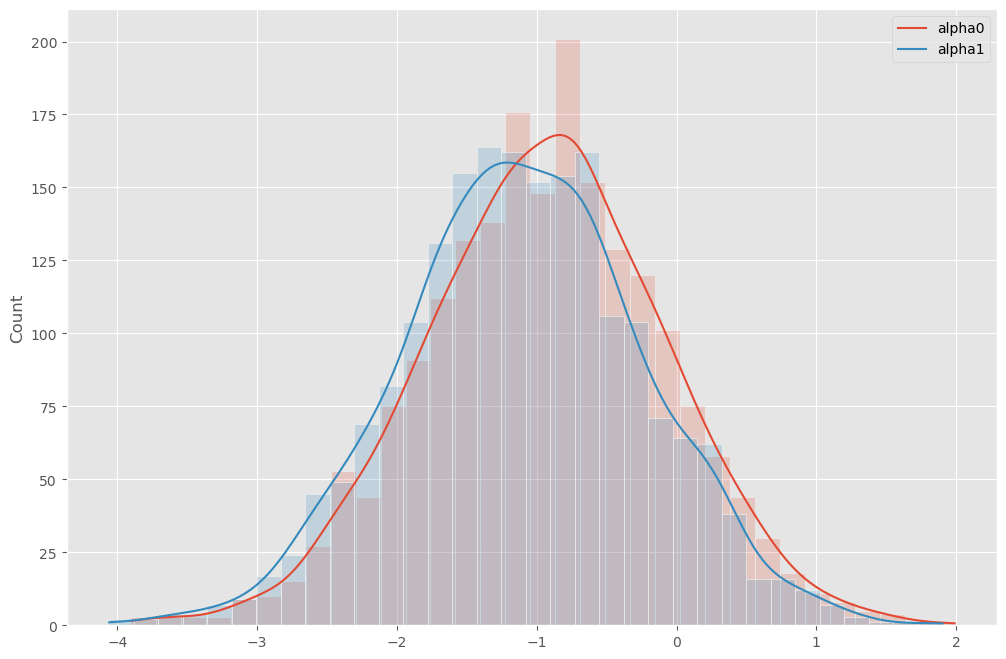

In [50]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

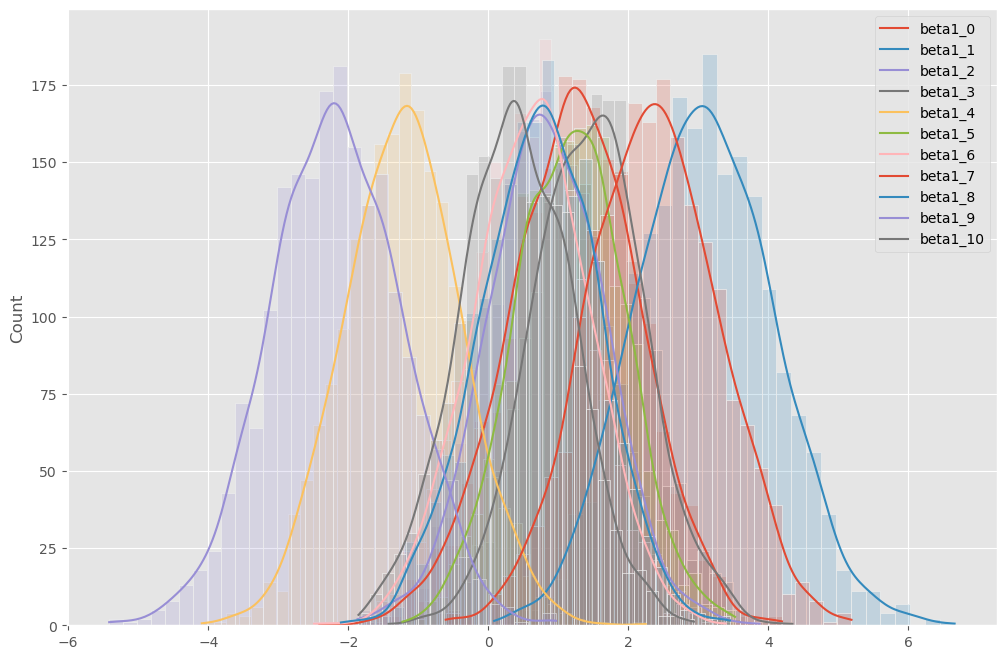

In [51]:
samples_beta = samples['beta'].detach().squeeze()
for d in range(X.shape[1]):
    sns.histplot(samples_beta[:,d,0], kde=True, alpha=0.2)
plt.legend(["beta1_%d" % d for d in range(X.shape[1])])
plt.show()

In [55]:
alpha_hat = samples_alpha.mean(axis=0).numpy()
beta_hat = samples_beta.mean(axis=0).numpy()

# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1
#print("predictions:", y_hat-1)
#print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum((y_hat-1) == y_test) / len(y_test))

# Der skal -1 på y_hat for den giver predictions med 1 og 2 istedet for 0 og 1

Accuracy: 0.8514851485148515
